In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
def save_pickle(path: str, contents):
    """Saves contents to a pickle file."""
    with open(path, "wb") as f:
        pickle.dump(contents, f)


def load_pickle(path: str):
    """Loads contents from a pickle file."""
    with open(path, "rb") as f:
        return pickle.load(f)
    

target_embedding = np.load("/data1/ReactionT5_neword/task_forward/output_ord/embedding_mean.npy")
print(target_embedding.shape)

(1801349, 768)


In [2]:
# apply UMAP and plot
from umap import UMAP
umap = UMAP(n_components=2)
target_embedding_umap = umap.fit_transform(target_embedding)
print(target_embedding_umap.shape)

/home/sagawa/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sagawa/miniconda3/lib/python3.11/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/sagawa/miniconda3/lib/python3.11/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/sagawa/miniconda3/lib/python3.11/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. T

(1801349, 2)


In [3]:
save_pickle("/data1/ReactionT5_neword/task_forward/output_ord/umap.pkl", umap)

/home/sagawa/miniconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [4]:
np.save("/data1/ReactionT5_neword/task_forward/output_ord/embedding_umap.npy", target_embedding_umap)

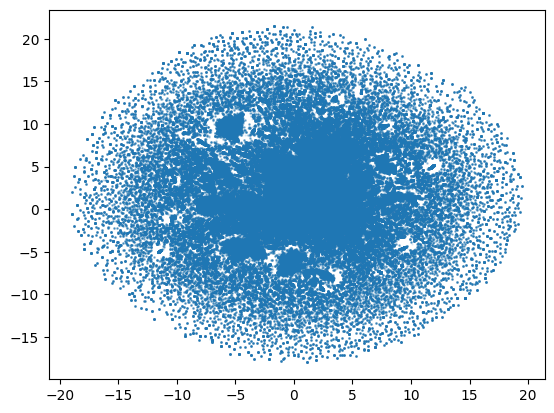

In [5]:
fig, ax = plt.subplots()
ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.1, s=0.5)

In [6]:
query_embedding = np.load("/data1/ReactionT5_neword/task_forward/output_uspto/embedding_mean.npy")
print(query_embedding.shape)

(409035, 768)


In [7]:
query_embedding_umap = umap.transform(query_embedding)
np.save("/data1/ReactionT5_neword/task_forward/output_uspto/query_embedding_umap.npy", query_embedding_umap)
print(query_embedding_umap.shape)

(409035, 2)


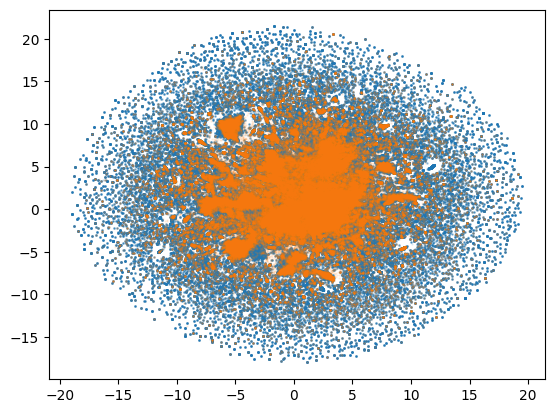

In [8]:
fig, ax = plt.subplots()
ax.scatter(target_embedding_umap[:, 0], target_embedding_umap[:, 1], alpha=0.1, s=0.5)
ax.scatter(query_embedding_umap[:, 0], query_embedding_umap[:, 1], alpha=0.1, s=0.5)